In [2]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from ExerciseAnswers import Answers

pylab.rcParams['figure.figsize'] = 10, 10

In [3]:
class Drone2D:
    
    def __init__(self,
                 k_f = 0.1, # value of the thrust coefficient
                 I_x = 0.1, # moment of inertia around the x-axis
                 m = 1.0,   # mass of the vehicle 
                 l = 0.5,   # distance between the center of 
                            #   mass and the propeller axis
                ):
        self.k_f = k_f
        self.I_x = I_x
        self.l = l 
        self.m = m
        self.omega_1 = 0.0
        self.omega_2 = 0.0
        self.g = 9.81
        
        # z, y, phi, z_dot, y_dot, phi_dot
        self.X = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
        
    def advance_state_uncontrolled(self,dt):
        """Advances the state of the drone by dt seconds. 
        Note that this method assumes zero rotational speed 
        for both propellers."""
        
        X_dot = np.array([
            self.X[3], 
            self.X[4], 
            self.X[5], 
            self.g, 
            0.0, 
            0.0])
        
        # Change in state will be 
        self.X = self.X + X_dot * dt
        return self.X
    
    def get_thrust_and_moment(self):
        """Helper function which calculates and returns the 
        collective thrust and the moment about the X axis"""
        f1 = self.k_f * self.omega_1 ** 2
        f2 = self.k_f * self.omega_2 ** 2
        
        # c is often used to indicate "collective" thrust
        c = f1 + f2
        M_x = (f1 - f2) * self.l
        return c, M_x

    @property
    def z_dot_dot(self):
        """Calculates vertical (z) acceleration of drone."""
        c, M_x = self.get_thrust_and_moment()
        phi = self.X[2]
        a_z = self.g - c * math.cos(phi) / self.m
        return a_z

    @property    
    def y_dot_dot(self):
        """Calculates lateral (y) acceleration of drone."""
        c, M_x = self.get_thrust_and_moment()
        phi = self.X[2]
        a_y = c * math.sin(phi) / self.m
        return a_y
    
    @property
    def phi_dot_dot(self):        
        c, M_x = self.get_thrust_and_moment()
        angular_acc = M_x / self.I_x
        return angular_acc
    
    def advance_state(self, dt): 
        """
        Advances the state of the drone forward by dt seconds.
        """
        X_dot = np.array([
            self.X[3], 
            self.X[4], 
            self.X[5], 
            self.z_dot_dot, 
            self.y_dot_dot, 
            self.phi_dot_dot])

        # Change in state will be 
        self.X = self.X + X_dot * dt
        return self.X
    
    def set_rotors_angular_velocities(self,linear_acc):
    
        omega = math.sqrt(self.m * (-linear_acc + self.g) /(2 * self.k_f))

        self.omega_1 = omega
        self.omega_2 = omega

        return self.omega_1, self.omega_2

In [6]:
drone = Drone2D()

stable_omega_1,stable_omega_2 = drone.set_rotors_angular_velocities(0.0)

print('Stable flight is achieved at propeller angular velocities of %5.2f' % stable_omega_1,
      'rad/sec')

Stable flight is achieved at propeller angular velocities of  7.00 rad/sec


Setting the roll to a $5^\circ$ angle and angular velocity for the first propeller to $\sqrt{1.1}$ above the level flight value and angular velocity for the second propeller to $\sqrt{1.05}$ above the level flight value.

In [7]:
drone.omega_1 = stable_omega_1 * math.sqrt(1.1)
drone.omega_2 = stable_omega_2 * math.sqrt(1.05)
drone.X[2] = 5*math.pi/180

vertical_acceleration = drone.z_dot_dot
print('Increase in %5.2f'%math.sqrt(1.1),' of the first propeller angular velocity and %5.2f'%math.sqrt(1.05),
      ' increase of the second propeller velocity while having 5 degree roll will result in'
      ,'%5.2f'%vertical_acceleration, 'm/(s*s) vertical acceleration.' )

Answers.vertical_acceleration(drone.m, drone.k_f,drone.g, drone.X[2], 
                              drone.omega_1, drone.omega_2, vertical_acceleration)

Increase in  1.05  of the first propeller angular velocity and  1.02  increase of the second propeller velocity while having 5 degree roll will result in -0.70 m/(s*s) vertical acceleration.


'You calculated the vertical acceleration value correctly'

In [8]:
horizontal_acceleration = drone.y_dot_dot
print('Increase in %5.2f'%math.sqrt(1.1),' of the first propeller angular velocity and %5.2f'%math.sqrt(1.05),
      ' increase of the second propeller velocity while having 5 degree roll will result in'
      ,'%5.2f'%vertical_acceleration, 'm/(s*s) horizontal acceleration.' )

Answers.horizontal_acceleration(drone.m, drone.k_f,drone.g, drone.X[2], 
                              drone.omega_1, drone.omega_2, horizontal_acceleration)

Increase in  1.05  of the first propeller angular velocity and  1.02  increase of the second propeller velocity while having 5 degree roll will result in -0.70 m/(s*s) horizontal acceleration.


'You calculated the vertical acceleration value correctly'

In [9]:
rolling_acceleration = drone.phi_dot_dot
print('Increase in %5.2f'%math.sqrt(1.1),' of the first propeller angular velocity and %5.2f'%math.sqrt(1.05),
      ' increase of the second propeller velocity will result in'
      ,'%5.2f'%rolling_acceleration, 'rad/(s*s) angular acceleration.' )

Answers.rolling_acceleration(drone.k_f, drone.I_x, drone.l,
                              drone.omega_1, drone.omega_2, rolling_acceleration)

Increase in  1.05  of the first propeller angular velocity and  1.02  increase of the second propeller velocity will result in  1.23 rad/(s*s) angular acceleration.


'You calculated the vertical acceleration value correctly'

# Following the vertical trajectory

In this section, we will generate the sinusoidal trajectory and will try to follow it by setting the angular velocities of the drone to achieve the desired acceleration.  
$$
z_{path}= 0.5 \cdot \cos(2t) - 0.5 \\
\ddot{z}_{path} = -2 \cdot \cos(2t)
$$


In [10]:
total_time = 3.0
dt = 0.01
t=np.linspace(0.0,total_time,int(total_time/dt))

z_path= 0.5*np.cos(2*t)-0.5
z_dot_dot_path= -2.0*np.cos(2*t)

In order to follow the path for each time instance, we will transfer the desired acceleration to the `set_rotors_angular_velocities` function which will get the propeller angular velocities. Next, we will obtain the updated state vector and save it in `drone_state_history`. Thus trucking the state vector evolution in time. 

In [11]:
drone = Drone2D()

drone_state_history = drone.X

for i in range(t.shape[0]-1):
    
    # setting the propeller velocities 
    drone.set_rotors_angular_velocities(z_dot_dot_path[i])
    
    # calculating the new state vector 
    drone_state = drone.advance_state(dt)
    
    # generate a history of vertical positions for drone
    drone_state_history = np.vstack((drone_state_history, drone_state))

Comparing the planned path to the one that has been executed.

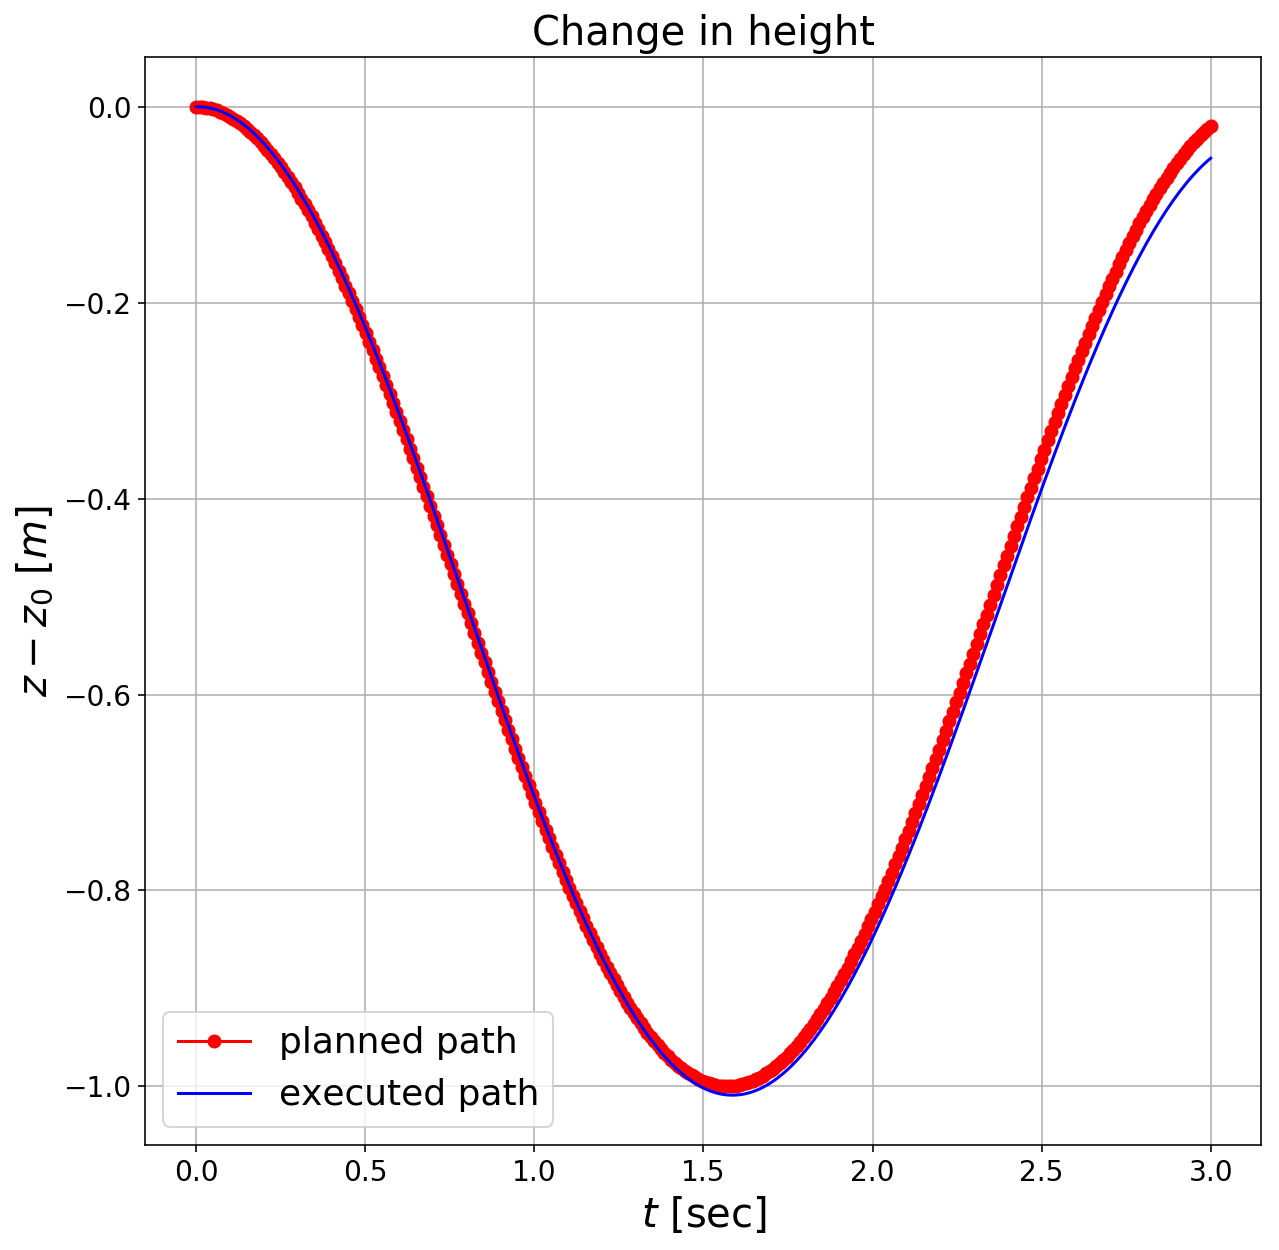

In [13]:
plt.plot(t,z_path,linestyle='-',marker='o',color='red')
plt.plot(t,drone_state_history[:,0],linestyle='-',color='blue')
plt.grid()
plt.title('Change in height').set_fontsize(20)
plt.xlabel('$t$ [sec]').set_fontsize(20)
plt.ylabel('$z-z_0$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['planned path','executed path'],fontsize = 18)
plt.show()